First, we load in the data.

In [1]:
import tensorflow as tf

In [2]:
import json
import csv

with open("./data/training_data_new.json", 'r') as f:
    datastore = json.load(f)

with open("./data/training_data_pj.json", 'r') as f:
    datastore += json.load(f)

headlines = []
labels = []

for item in datastore:
    headlines.append(item['title'])
    labels.append(item['good_news'])

with open("./data/kaggle.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for line in reader:
        label = line[0]
        headline = line[1]
        # if random.randint(0, 1) >= .5:
        #     continue
        if label == "positive":
            labels.append(1)
        else:
            labels.append(0)
        headlines.append(headline)

print(labels.count(0), labels.count(1))

3851 2537


Download nltk resources

In [ ]:
import nltk
nltk.download ()

Remove stop words and contractions.

In [3]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer, SnowballStemmer
import re

lem = False
stem = True
v2 = True

if v2:
    stemmer = SnowballStemmer(language='english')
else:
    stemmer = PorterStemmer()
lemmmatizer = WordNetLemmatizer()

def preProcess(sentence):
    words = []
    for word in sentence.split():
        #Take out all non letter characters
        #word = re.sub("[^a-zA-Z]+", "", word.lower())
        word = word.lower()
        if word not in stopwords.words('english') and word != "":
            if lem:
                newWord = lemmmatizer.lemmatize(word)
            elif stem:
                newWord = stemmer.stem(word)
            else:
                newWord = word
            words.append(newWord.replace("'", ""))

    return ' '.join(words)


In [4]:
for i in range(len(headlines)):
    headlines[i] = preProcess(headlines[i])

Split the data.

In [5]:
from sklearn.model_selection import train_test_split
training_headlines, testing_headlines, training_labels, testing_labels = train_test_split(headlines, labels, train_size=0.90)
print(f"Split into {len(training_headlines)} Training sets and {len(testing_headlines)} Testing sets.")

Split into 5749 Training sets and 639 Testing sets.


Tune Hyperparameters.

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 35
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# training tokenizer
#tokenizer.word_index = word_index

tokenizer.fit_on_texts(training_headlines)

print(f"Word Index Size: {len(tokenizer.word_index)}")

# adding padding 
training_sequences = tokenizer.texts_to_sequences(training_headlines)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_headlines)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

Word Index Size: 9313


Define MCC Metric

In [45]:
threshold = 0.5  

def mcc_metric(y_true, y_pred):
  predicted = tf.cast(tf.greater(y_pred, threshold), tf.float32)
  true_pos = tf.math.count_nonzero(predicted * y_true)
  true_neg = tf.math.count_nonzero((predicted - 1) * (y_true - 1))
  false_pos = tf.math.count_nonzero(predicted * (y_true - 1))
  false_neg = tf.math.count_nonzero((predicted - 1) * y_true)
  x = tf.cast((true_pos + false_pos) * (true_pos + false_neg) 
      * (true_neg + false_pos) * (true_neg + false_neg), tf.float32)
  return tf.cast((true_pos * true_neg) - (false_pos * false_neg), tf.float32) / tf.sqrt(x)

In [55]:
embedding_dim = 16
batch_size = 32
epochs = 50
learning_rate = 1e-4

In [56]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),#, return_sequences=False, dropout=0.25, recurrent_dropout=0.25)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=["accuracy", mcc_metric, tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])

Train model.

In [48]:
idx = 11

In [40]:
class prediction_for_each_epoch(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        prediction = model.predict(np.expand_dims(testing_padded[idx], axis=0))
        print(f"\n Prediction: {prediction[0][0]} Actual: {testing_labels[idx]}")

In [58]:
stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

string = ""
for word in testing_padded[idx]:
    if word == 0:
        string += "."
        break
    string += tokenizer.index_word[word] + " "
print(f"Sentence is '{string}'")

history = model.fit(training_padded, training_labels, batch_size=batch_size, epochs=epochs, validation_data=(testing_padded, testing_labels), callbacks=[stop, prediction_for_each_epoch()])

Sentence is '424b5 form prospectus rule 424 b 5 verrica pharmaceut inc 0001660334 filer .'
Epoch 1/50
178/180 [============================>.] - ETA: 0s - loss: 0.6608 - accuracy: 0.6192 - mcc_metric: nan - false_positives: 77.0000 - false_negatives: 2092.0000
 Prediction: 0.5572219491004944 Actual: 1
180/180 [==============================] - 7s 38ms/step - loss: 0.6604 - accuracy: 0.6199 - mcc_metric: nan - false_positives: 78.0000 - false_negatives: 2107.0000 - val_loss: 0.6032 - val_accuracy: 0.6682 - val_mcc_metric: 0.2867 - val_false_positives: 18.0000 - val_false_negatives: 194.0000
Epoch 2/50
179/180 [============================>.] - ETA: 0s - loss: 0.5464 - accuracy: 0.7320 - mcc_metric: nan - false_positives: 534.0000 - false_negatives: 1001.0000
 Prediction: 0.8423881530761719 Actual: 1
180/180 [==============================] - 6s 31ms/step - loss: 0.5465 - accuracy: 0.7318 - mcc_metric: nan - false_positives: 540.0000 - false_negatives: 1002.0000 - val_loss: 0.5245 - val_

Plot findings.

In [51]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

def plot_lr(history):
    lrs = 1e-8 * (10 ** (np.arange(epochs) / 20))

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Set the grid
    plt.grid(True)

    # Plot the loss in log scale
    plt.semilogx(lrs, history.history["val_loss"])

    # Increase the tickmarks size
    plt.tick_params('both', length=10, width=1, which='both')

    # Set the plot boundaries
    plt.axis([1e-8, 1e-3, 0, 2])
    plt.show()

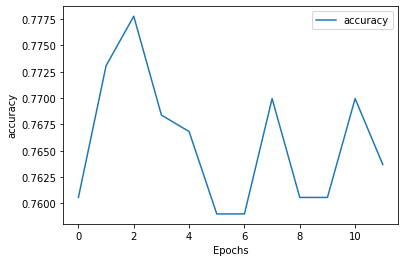

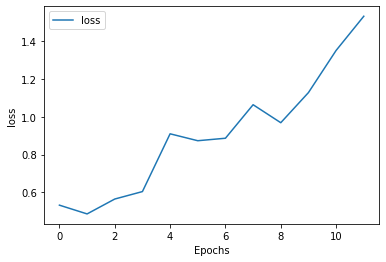

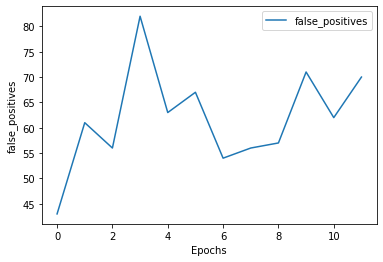

In [52]:
#plot_lr(history)
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "false_positives")

Make predictions

In [ ]:
def predict(sentences):
    if type(sentences) != list:
        sentences = [sentences]
    for i in range(len(sentences)):
        sentences[i] = preProcess(sentences[i])
    
    sequences = tokenizer.texts_to_sequences(sentences)
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    
    return model.predict(padded)

    

In [ ]:
print(predict("Wedbush Downgrades Redfin to Neutral, Lowers Price Target to $9"))

Download Embedding Space

In [ ]:
import io

# Open writeable files
out_v = io.open('embeds/vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('embeds/meta.tsv', 'w', encoding='utf-8')

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, len(tokenizer.word_index)):

  # Get the word associated at the current index
  word_name = tokenizer.index_word[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

Save model

In [59]:
model.save("models/model.h5")
with open("models/word_index.json", "w+", encoding="utf-8") as _file:
    _file.write(json.dumps(tokenizer.word_index, indent=4))